In [1]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.utils.data as Data
import torch

In [2]:
# 手写数字训练数据集
mnist = np.load("../../../../Other/datasets/NumPy/mnist.npz")
X_train, y_train, X_val, y_val = torch.unsqueeze(torch.tensor(mnist['x_train']), 1).to(dtype=torch.float32), \
                                   torch.tensor(mnist['y_train']).to(dtype=torch.long), \
                                   torch.unsqueeze(torch.tensor(mnist['x_test']), 1).to(dtype=torch.float32), \
                                   torch.tensor(mnist['y_test']).to(dtype=torch.long)
X_train, X_val = X_train / 255.0, X_val / 255.0

In [3]:
batch_size = 200
train_data = Data.TensorDataset(X_train, y_train)
train_loader = Data.DataLoader(dataset=train_data,
                               batch_size=batch_size,
                               shuffle=True)
val_data = Data.TensorDataset(X_val, y_val)
val_loader = Data.DataLoader(dataset=val_data, batch_size=batch_size)

In [4]:
print(len(train_loader))
print(len(train_loader.dataset))

300
60000


In [5]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.featrues = nn.Sequential(  # 内部实现了forward函数;各模块顺序执行
            nn.Conv2d(1, 6, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(400, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),  # 10分类问题
        )

    def forward(self, x):
        x = self.featrues(x)
        x = x.reshape(x.size()[0], -1)
        x = self.classifier(x)
        return x


In [6]:
learning_rate = 0.001
criteon = nn.CrossEntropyLoss()  # 定义损失函数为交叉熵
net = LeNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lenet = net.to(device)  # 模型设备转移必须在优化器定义前执行

# Adam优化器
optimizer = optim.Adam(net.parameters(),
                       lr=learning_rate,  # 学习率\epsilon;默认lr=0.001
                       weight_decay=1e-3,  # L2正则化系数,默认weight_decay=0
                       betas=(0.9, 0.999),  # \rho_1, \rho_2;默认betas=(0.9, 0.999)
                       eps=1e-8)  # 分母中的小常数\delta;默认eps=1e-8


In [8]:
from J_Template.assembly.模型训练与评估_torch.train_evaluate import Train_Evaluate

t_and_v = Train_Evaluate(model=lenet, optimizer=optimizer, criterion=criteon, epochs=20)

In [9]:
metric_reslut = t_and_v.train_eval(train_loader=train_loader, valid_loader=val_loader)
print(metric_reslut)  # 每一轮验证数据集的损失值

Train Epoch: 0  [0    /60000 (0  %)]	Loss: 2.299319
Train Epoch: 0  [4000 /60000 (7  %)]	Loss: 2.094661
Train Epoch: 0  [8000 /60000 (13 %)]	Loss: 1.168292
Train Epoch: 0  [12000/60000 (20 %)]	Loss: 0.687662
Train Epoch: 0  [16000/60000 (27 %)]	Loss: 0.635613
Train Epoch: 0  [20000/60000 (33 %)]	Loss: 0.493830
Train Epoch: 0  [24000/60000 (40 %)]	Loss: 0.496526
Train Epoch: 0  [28000/60000 (47 %)]	Loss: 0.309240
Train Epoch: 0  [32000/60000 (53 %)]	Loss: 0.382079
Train Epoch: 0  [36000/60000 (60 %)]	Loss: 0.394308
Train Epoch: 0  [40000/60000 (67 %)]	Loss: 0.330352
Train Epoch: 0  [44000/60000 (73 %)]	Loss: 0.228366
Train Epoch: 0  [48000/60000 (80 %)]	Loss: 0.265083
Train Epoch: 0  [52000/60000 (87 %)]	Loss: 0.167139
Train Epoch: 0  [56000/60000 (93 %)]	Loss: 0.326510
Train Epoch: 0  [60000/60000 (100%)]	Loss: 0.216184
----------------------------------------------------------------------------------------------------
Train Epoch: 1  [0    /60000 (0  %)]	Loss: 0.200911
Train Epoch: 1 

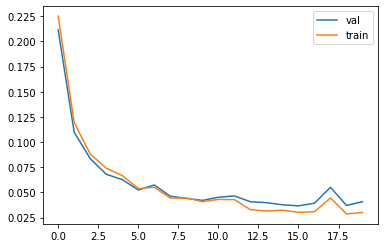

In [10]:
import matplotlib.pyplot as plt
plt.plot(metric_reslut['val_loss'], label="val")
plt.plot(metric_reslut['train_loss'], label='train')
plt.legend()
plt.show()